In [1]:
import os
import json
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from together import Together
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Together client
load_dotenv()

MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.3"
TOGETHER_API_KEY = os.environ["TOGETHER_API_KEY"]

client = Together(api_key=TOGETHER_API_KEY)

In [2]:
with open('/Users/alexlecu/PycharmProjects/LLMKGraph/backend/evaluation/data/grok_evaluation_datasets/2_Hop_True_or_False_Questions.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame for analysis
df = pd.DataFrame(data)
df = df[['question', 'answer']]

# Add columns for evaluation
df['contexts'] = None  # Will be filled with retrieved passages
df['with_context_answer'] = None  # Will be filled with RAG responses
df['without_context_answer'] = None  # Will be filled with model-only responses

In [3]:
from weaviate_rag.rag_system import GraphRAGSystem

# Configure for Together AI
model_config = {
    'provider': 'together',
    'model_name': MODEL_NAME,
    'api_key': TOGETHER_API_KEY
}


In [4]:
def generate_answer_with_context_together(question, context, model=MODEL_NAME):
    user_prompt = f"""Given the following medical information, determine if the statement below is True or False.

    MEDICAL INFORMATION:
    {context}
    
    STATEMENT TO VERIFY:
    {question}
    
    IMPORTANT: Respond with ONLY the word "True" or "False".
    """
    
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a medical knowledge assistant."},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.1,
            top_p=0.9,
            max_tokens=10
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error with Together API: {e}")
        time.sleep(1)  # Rate limiting
        return None

def generate_answer_without_context_together(question, model=MODEL_NAME):
    """Generate answer using Together AI without context"""
    user_prompt = f"""
    Determine if this medical statement is TRUE or FALSE based on your knowledge.
    
    STATEMENT TO VERIFY:
    {question}
    
    IMPORTANT: Respond with ONLY the word "True" or "False".
    """
    
    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a medical knowledge assistant."},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0.1,
            top_p=0.9,
            max_tokens=10
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error with Together API: {e}")
        time.sleep(1)
        return None

In [5]:
def parse_true_false(response):
    """Parse the response to extract True/False answer"""
    if response is None:
        return None
        
    # Clean up response
    response = response.strip().lower()
    
    # Check for True/False keywords
    if "true" in response:
        return True
    elif "false" in response:
        return False
    else:
        print(f"Warning: Could not parse true/false from: '{response}'")
        return None

In [6]:
results = []

for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing"):
    question = row['question']
    
    try:
        # Generate context using Together AI (end-to-end evaluation)
        analyzer = GraphRAGSystem(question, model_config)
        context = analyzer.analyze()
        
        # Generate answers
        with_context = generate_answer_with_context_together(question, context)
        without_context = generate_answer_without_context_together(question)
               
        df.at[idx, 'contexts'] = context
        df.at[idx, 'with_context_answer'] = with_context
        df.at[idx, 'without_context_answer'] = without_context
        
        # Rate limiting
        time.sleep(0.5)
        
    except Exception as e:
        print(f"Error on question {idx}: {e}")
        df.at[idx, 'contexts'] = None
        df.at[idx, 'with_context_answer'] = None
        df.at[idx, 'without_context_answer'] = None

Processing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [03:37<00:00,  2.83s/it]


In [7]:
# Parse responses into boolean values
df['with_context_parsed'] = df['with_context_answer'].apply(parse_true_false)
df['without_context_parsed'] = df['without_context_answer'].apply(parse_true_false)

# Display results
print("Parsed Results:")
for index, row in df.iterrows():
    print(f"Question {index+1}: {row['question']}")
    print(f"Ground Truth: {row['answer']}")
    print(f"With Context: {row['with_context_parsed']}")
    print(f"Without Context: {row['without_context_parsed']}\n")

# Prepare for evaluation
references = df['answer'].tolist()
with_context_responses = df['with_context_parsed'].tolist()
without_context_responses = df['without_context_parsed'].tolist()

Parsed Results:
Question 1: Can dry AMD progress to wet AMD because of oxidative stress alone?
Ground Truth: False
With Context: True
Without Context: True

Question 2: Can photodynamic therapy treat wet AMD by reducing oxidative stress in the retina?
Ground Truth: False
With Context: True
Without Context: True

Question 3: Does a family history of AMD increase risk by altering retinal blood flow?
Ground Truth: False
With Context: False
Without Context: True

Question 4: Does high blood pressure exacerbate AMD by increasing retinal hemorrhages?
Ground Truth: False
With Context: True
Without Context: True

Question 5: Does family history elevate AMD risk by increasing susceptibility to retinal inflammation?
Ground Truth: True
With Context: True
Without Context: True

Question 6: Can wet AMD cause sudden vision loss by rupturing the Bruch’s membrane?
Ground Truth: True
With Context: False
Without Context: True

Question 7: Can photodynamic therapy manage wet AMD by eliminating oxidative 

In [8]:
# Calculate metrics for with-context responses
with_context_metrics = {}

# Filter out None values
valid_indices = [i for i, x in enumerate(with_context_responses) if x is not None]
valid_refs = [references[i] for i in valid_indices]
valid_preds = [with_context_responses[i] for i in valid_indices]

if valid_preds:
    with_context_metrics['accuracy'] = accuracy_score(valid_refs, valid_preds)
    with_context_metrics['precision'] = precision_score(valid_refs, valid_preds)
    with_context_metrics['recall'] = recall_score(valid_refs, valid_preds)
    with_context_metrics['f1'] = f1_score(valid_refs, valid_preds)
    with_context_metrics['confusion_matrix'] = confusion_matrix(valid_refs, valid_preds)
    
    # Print evaluation results
    print("\nWith Context - Evaluation Metrics:")
    print(f"Accuracy: {with_context_metrics['accuracy']:.2f} ({with_context_metrics['accuracy'] * 100:.1f}%)")
    print(f"Precision: {with_context_metrics['precision']:.2f}")
    print(f"Recall: {with_context_metrics['recall']:.2f}")
    print(f"F1-Score: {with_context_metrics['f1']:.2f}")
    print(f"Confusion Matrix:\n{with_context_metrics['confusion_matrix']}")
else:
    print("No valid predictions to evaluate for with-context responses")


With Context - Evaluation Metrics:
Accuracy: 0.21 (20.8%)
Precision: 0.18
Recall: 0.19
F1-Score: 0.19
Confusion Matrix:
[[ 9 32]
 [29  7]]


In [9]:
# Calculate metrics for without-context responses
without_context_metrics = {}

# Filter out None values
valid_indices = [i for i, x in enumerate(without_context_responses) if x is not None]
valid_refs = [references[i] for i in valid_indices]
valid_preds = [without_context_responses[i] for i in valid_indices]

if valid_preds:
    without_context_metrics['accuracy'] = accuracy_score(valid_refs, valid_preds)
    without_context_metrics['precision'] = precision_score(valid_refs, valid_preds)
    without_context_metrics['recall'] = recall_score(valid_refs, valid_preds)
    without_context_metrics['f1'] = f1_score(valid_refs, valid_preds)
    without_context_metrics['confusion_matrix'] = confusion_matrix(valid_refs, valid_preds)
    
    # Print evaluation results
    print("\nWithout Context - Evaluation Metrics:")
    print(f"Accuracy: {without_context_metrics['accuracy']:.2f} ({without_context_metrics['accuracy'] * 100:.1f}%)")
    print(f"Precision: {without_context_metrics['precision']:.2f}")
    print(f"Recall: {without_context_metrics['recall']:.2f}")
    print(f"F1-Score: {without_context_metrics['f1']:.2f}")
    print(f"Confusion Matrix:\n{without_context_metrics['confusion_matrix']}")
else:
    print("No valid predictions to evaluate for without-context responses")


Without Context - Evaluation Metrics:
Accuracy: 0.65 (64.9%)
Precision: 0.60
Recall: 0.78
F1-Score: 0.67
Confusion Matrix:
[[22 19]
 [ 8 28]]


In [10]:
# Compare errors between with-context and without-context approaches
print("\nError Analysis:")
print("-" * 80)
print(f"{'Question':50} | {'Ground Truth':12} | {'With Context':12} | {'Without Context':15} | {'Notes'}") 
print("-" * 80)

for i, row in df.iterrows():
    # Check if either prediction is incorrect
    with_context_correct = row['with_context_parsed'] == row['answer'] if row['with_context_parsed'] is not None else False
    without_context_correct = row['without_context_parsed'] == row['answer'] if row['without_context_parsed'] is not None else False
    
    # Only show questions where at least one approach was incorrect
    if not (with_context_correct and without_context_correct):
        question = row['question'][:47] + "..." if len(row['question']) > 50 else row['question'].ljust(50)
        ground_truth = str(row['answer']).ljust(12)
        with_context = str(row['with_context_parsed']).ljust(12)
        without_context = str(row['without_context_parsed']).ljust(15)
        
        # Determine notes
        if with_context_correct and not without_context_correct:
            notes = "Context helped"
        elif not with_context_correct and without_context_correct:
            notes = "Context misled"
        else:
            notes = "Both incorrect"
            
        print(f"{question} | {ground_truth} | {with_context} | {without_context} | {notes}")


Error Analysis:
--------------------------------------------------------------------------------
Question                                           | Ground Truth | With Context | Without Context | Notes
--------------------------------------------------------------------------------
Can dry AMD progress to wet AMD because of oxid... | False        | True         | True            | Both incorrect
Can photodynamic therapy treat wet AMD by reduc... | False        | True         | True            | Both incorrect
Does a family history of AMD increase risk by a... | False        | False        | True            | Context helped
Does high blood pressure exacerbate AMD by incr... | False        | True         | True            | Both incorrect
Can wet AMD cause sudden vision loss by rupturi... | True         | False        | True            | Context misled
Can photodynamic therapy manage wet AMD by elim... | False        | True         | True            | Both incorrect
Does dry AMD progr

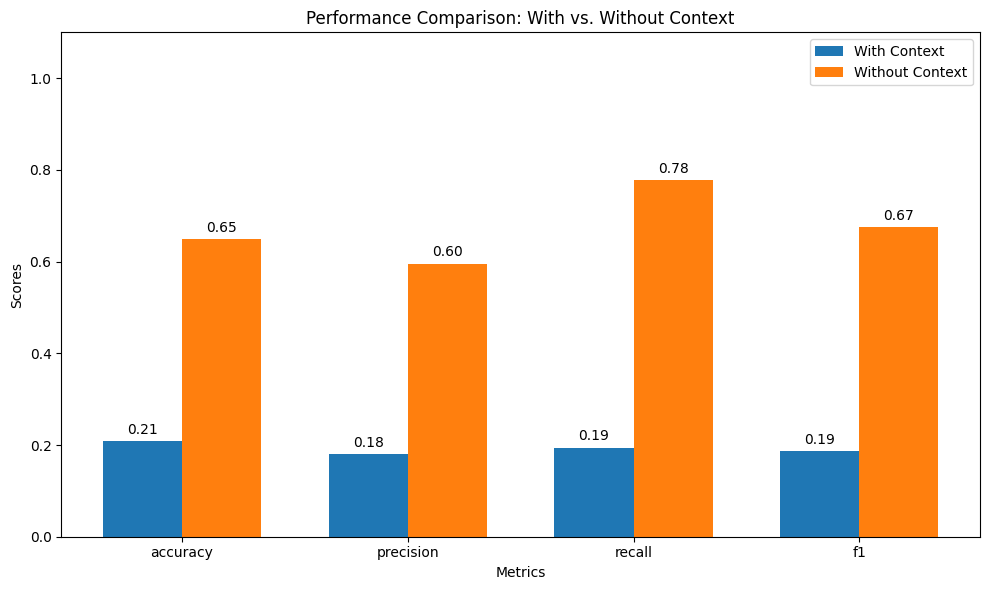

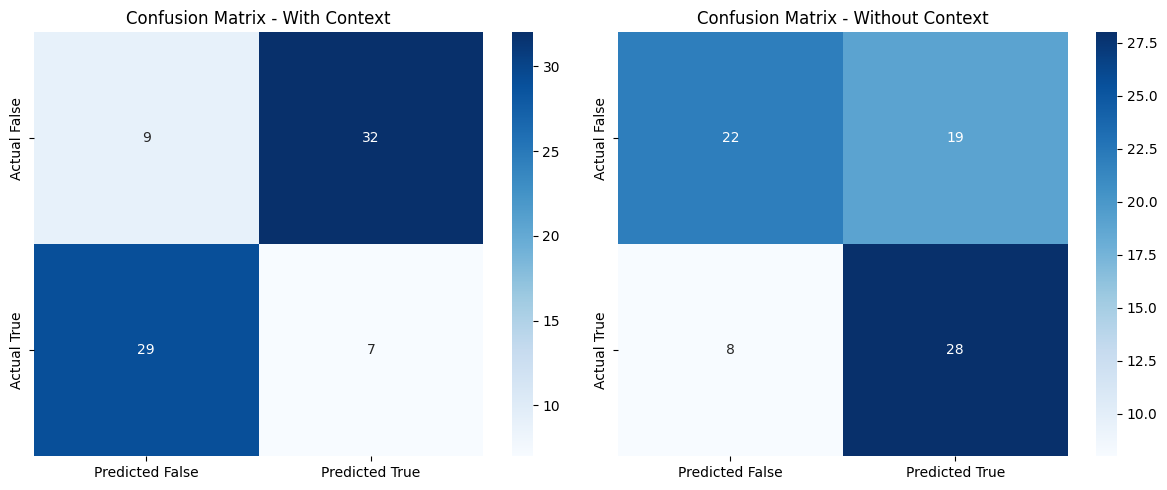

In [11]:
# Visualize metrics comparison
if with_context_metrics and without_context_metrics:
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    with_context_values = [with_context_metrics[m] for m in metrics]
    without_context_values = [without_context_metrics[m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, with_context_values, width, label='With Context')
    rects2 = ax.bar(x + width/2, without_context_values, width, label='Without Context')
    
    # Add labels and title
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title('Performance Comparison: With vs. Without Context')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.set_ylim(0, 1.1)
    
    # Add value labels
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    add_labels(rects1)
    add_labels(rects2)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # With context confusion matrix
    sns.heatmap(with_context_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Predicted False', 'Predicted True'],
                yticklabels=['Actual False', 'Actual True'])
    ax1.set_title('Confusion Matrix - With Context')
    
    # Without context confusion matrix
    sns.heatmap(without_context_metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=ax2,
                xticklabels=['Predicted False', 'Predicted True'],
                yticklabels=['Actual False', 'Actual True'])
    ax2.set_title('Confusion Matrix - Without Context')
    
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data to visualize comparison")


Context Impact Summary:
Negative: 36 questions (46.8%)
No Help: 25 questions (32.5%)
Neutral: 14 questions (18.2%)
Positive: 2 questions (2.6%)


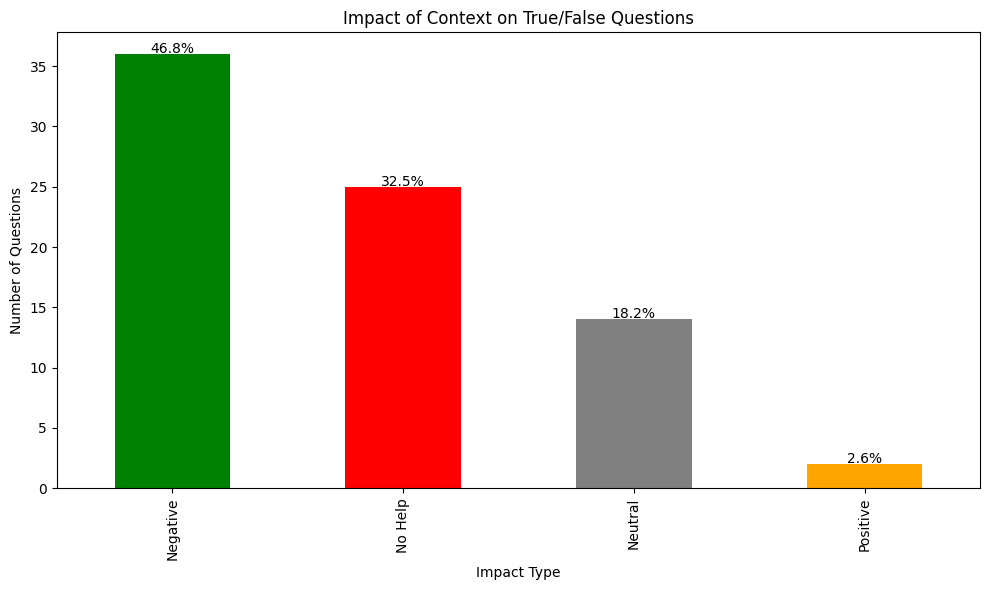

In [12]:
# Analyze the impact of context on each question
df['context_impact'] = None

for i, row in df.iterrows():
    # Skip if either prediction is None
    if row['with_context_parsed'] is None or row['without_context_parsed'] is None:
        df.at[i, 'context_impact'] = 'Unknown'
        continue
        
    with_correct = row['with_context_parsed'] == row['answer']
    without_correct = row['without_context_parsed'] == row['answer']
    
    if with_correct and not without_correct:
        df.at[i, 'context_impact'] = 'Positive'
    elif not with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Negative'
    elif with_correct and without_correct:
        df.at[i, 'context_impact'] = 'Neutral'
    else:  # both incorrect
        df.at[i, 'context_impact'] = 'No Help'

# Summarize context impact
impact_counts = df['context_impact'].value_counts()
print("\nContext Impact Summary:")
for impact, count in impact_counts.items():
    print(f"{impact}: {count} questions ({count/len(df)*100:.1f}%)")

# Visualize context impact
plt.figure(figsize=(10, 6))
ax = impact_counts.plot(kind='bar', color=['green', 'red', 'gray', 'orange'])
plt.title('Impact of Context on True/False Questions')
plt.xlabel('Impact Type')
plt.ylabel('Number of Questions')

# Add percentages on top of bars
for i, v in enumerate(impact_counts):
    ax.text(i, v + 0.1, f"{v/len(df)*100:.1f}%", ha='center')

plt.tight_layout()
plt.show()

In [13]:
# Generate a summary report
print("\n" + "=" * 80)
print("EVALUATION SUMMARY REPORT")
print("=" * 80)
print(f"Total Questions: {len(df)}")
print(f"True Answers: {sum(df['answer'])}")
print(f"False Answers: {len(df) - sum(df['answer'])}")
print("\nPerformance Summary:")

if with_context_metrics and without_context_metrics:
    print(f"With Context Accuracy: {with_context_metrics['accuracy']:.2f} ({with_context_metrics['accuracy']*100:.1f}%)")
    print(f"Without Context Accuracy: {without_context_metrics['accuracy']:.2f} ({without_context_metrics['accuracy']*100:.1f}%)")
    
    # Determine if context helped overall
    if with_context_metrics['accuracy'] > without_context_metrics['accuracy']:
        diff = with_context_metrics['accuracy'] - without_context_metrics['accuracy']
        print(f"\nContext improved accuracy by {diff:.2f} ({diff*100:.1f}%)")
    elif with_context_metrics['accuracy'] < without_context_metrics['accuracy']:
        diff = without_context_metrics['accuracy'] - with_context_metrics['accuracy']
        print(f"\nContext decreased accuracy by {diff:.2f} ({diff*100:.1f}%)")
    else:
        print("\nContext had no overall impact on accuracy")

# List questions where context helped
helped_questions = df[df['context_impact'] == 'Positive']
if not helped_questions.empty:
    print("\nQuestions where context helped:")
    for i, row in helped_questions.iterrows():
        print(f"- {row['question']}")

# List questions where context was misleading
misled_questions = df[df['context_impact'] == 'Negative']
if not misled_questions.empty:
    print("\nQuestions where context was misleading:")
    for i, row in misled_questions.iterrows():
        print(f"- {row['question']}")

print("\nConclusions:")
print("1. Context retrieval" + (" improved " if with_context_metrics.get('accuracy', 0) > without_context_metrics.get('accuracy', 0) else " did not improve ") + "overall accuracy for true/false questions.")
print(f"2. {impact_counts.get('Positive', 0)} questions benefited from context, while {impact_counts.get('Negative', 0)} questions were negatively affected.")
print("3. Recommendations:")
print("   - " + ("Continue using RAG for true/false questions" if with_context_metrics.get('accuracy', 0) > without_context_metrics.get('accuracy', 0) else "Improve context retrieval or consider limiting RAG for true/false questions"))
print("   - Consider a hybrid approach that evaluates context quality before deciding whether to use it")
print("   - Expand the evaluation dataset to include more diverse true/false questions")


EVALUATION SUMMARY REPORT
Total Questions: 77
True Answers: 36
False Answers: 41

Performance Summary:
With Context Accuracy: 0.21 (20.8%)
Without Context Accuracy: 0.65 (64.9%)

Context decreased accuracy by 0.44 (44.2%)

Questions where context helped:
- Does a family history of AMD increase risk by altering retinal blood flow?
- Does UV light exposure worsen AMD by causing retinal pigment epithelial swelling?

Questions where context was misleading:
- Can wet AMD cause sudden vision loss by rupturing the Bruch’s membrane?
- Does dry AMD progress slowly because it avoids photoreceptor regeneration?
- Can photodynamic therapy treat wet AMD by reducing blood vessel leakage?
- Does high cholesterol contribute to AMD by increasing drusen formation?
- Does high blood pressure worsen AMD by causing choroidal hemorrhages?
- Does dry AMD cause gradual vision loss by affecting the optic nerve?
- Can anti-VEGF injections treat wet AMD by preventing subretinal hemorrhages?
- Can OCT diagnose w

In [14]:
df.to_csv('output_mistral7b_2hop_true_and_false.csv', index=False)